<a href="https://colab.research.google.com/github/jith4j/Tuberculosis-Classification/blob/main/Tuber_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 The Dataset

## 1.1 Kaggle API json token

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## 1.2 Download the dataset

By providing the Kaggle Dataset API command.

In [ ]:
! kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

100% 961M/961M [00:17<00:00, 88.4MB/s]
100% 961M/961M [00:17<00:00, 58.8MB/s]


## 1.3 Unzipping


In [ ]:
import zipfile
zf = "/content/tuberculosis-tb-chest-xray-dataset.zip"
target_dir = "/content/dataset/cnn/tuberculosis_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

## 1.4 Spliting to Train, Validation, Test

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders 

splitfolders.ratio(
    "/content/dataset/cnn/tuberculosis_revamped/TB_Chest_Radiography_Database", 
    output="/content/dataset/cnn/tuberculosis", 
    seed=1337, 
    ratio=(.7, .2, .1), 
    group_prefix=None
)


Copying files: 7000 files [00:15, 448.11 files/s]


In [ ]:
!rm -r "/content/dataset/cnn/tuberculosis_revamped"

Following code is to make test directory have a single folder with both Normal and Tuberculosis datas.
In our case we do not require this part of the code hence its commented.

In [ ]:
# !mv  -v /content/dataset/cnn/tuberculosis/test/Normal/* /content/dataset/cnn/tuberculosis/test/
# !mv  -v /content/dataset/cnn/tuberculosis/test/Tuberculosis/* /content/dataset/cnn/tuberculosis/test/
# !rm -r /content/dataset/cnn/tuberculosis/test/Normal
# !rm -r /content/dataset/cnn/tuberculosis/test/Tuberculosis

# 2 Initialize

## 2.1 Basic Imports

In [ ]:
#Some Basic Imports
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data

## 2.2 Define Directories

In [ ]:
#Define Directories for train, test & Validation Set
train_path = '/content/dataset/cnn/tuberculosis/train'
test_path = '/content/dataset/cnn/tuberculosis/test'
valid_path = '/content/dataset/cnn/tuberculosis/val'

## 2.3 Basic Parameters

In [ ]:
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16 
#The dimension of the images we are going to define is 500x500 img_height = 500
img_height = 500
img_width = 500

# 3 Preparing the Data

## 3.1 Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                rescale = 1./255,
                                #shear_range = 0,
                                #zoom_range = 0,
                                horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
      class_mode='binary',
      batch_size=batch_size
      )

valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 4900 images belonging to 2 classes.
Found 700 images belonging to 2 classes.
Found 1400 images belonging to 2 classes.


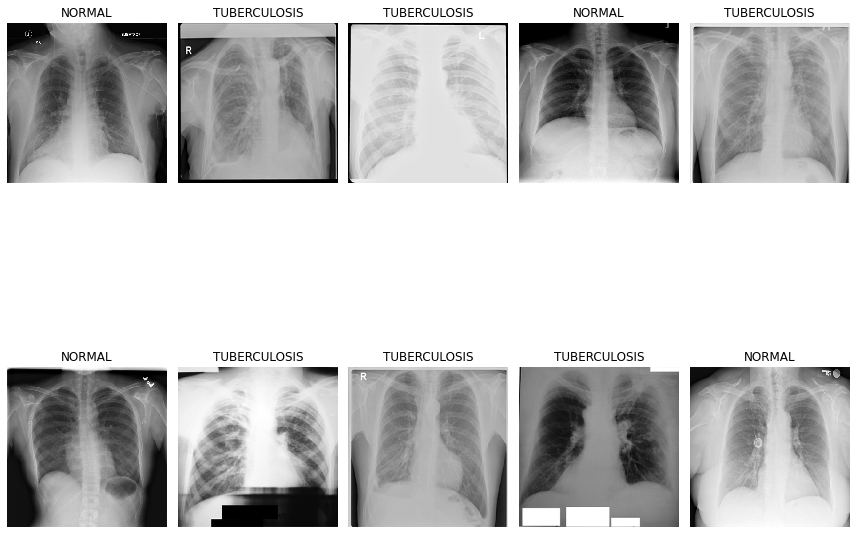

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'TUBERCULOSIS'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# 4 Convolutional Neural Network

## 4.1 Necessary Imports

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

## 4.2 CNN Architecture

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))

Model Compile

In [ ]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model Summary

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        1

Visualize CNN model

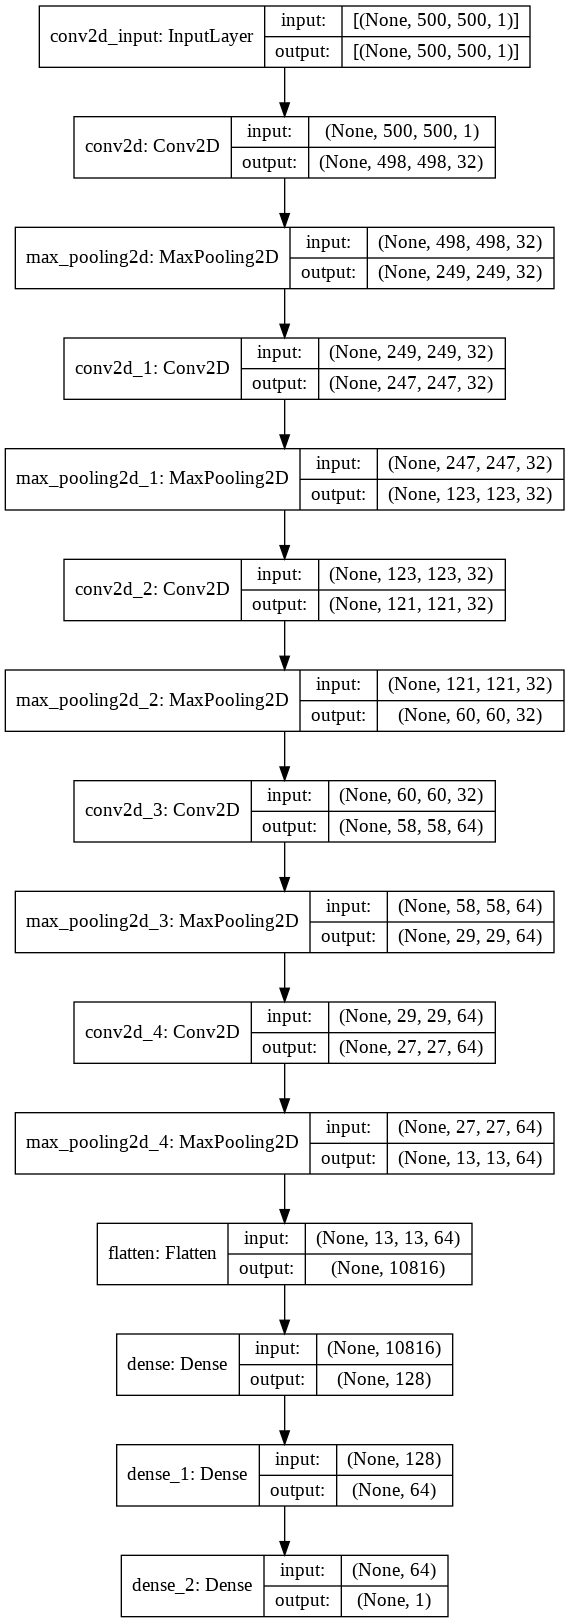

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

## 4.3 Fit the model

Defining callback list

In [ ]:
early = EarlyStopping(monitor= "val_loss", mode= "min", patience= 3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

Assigning Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.0, 1: 1.0}


Training

In [ ]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
307/307 [==============================] - 109s 253ms/step - loss: 0.4736 - accuracy: 0.7789 - val_loss: 0.2305 - val_accuracy: 0.9071
Epoch 2/25
307/307 [==============================] - 75s 244ms/step - loss: 0.2643 - accuracy: 0.8889 - val_loss: 0.1558 - val_accuracy: 0.9400
Epoch 3/25
307/307 [==============================] - 75s 243ms/step - loss: 0.1880 - accuracy: 0.9351 - val_loss: 0.1688 - val_accuracy: 0.9307
Epoch 4/25
307/307 [==============================] - 75s 244ms/step - loss: 0.1377 - accuracy: 0.9444 - val_loss: 0.1258 - val_accuracy: 0.9514
Epoch 5/25
307/307 [==============================] - 75s 244ms/step - loss: 0.1265 - accuracy: 0.9524 - val_loss: 0.0998 - val_accuracy: 0.9636
Epoch 6/25
307/307 [==============================] - 75s 244ms/step - loss: 0.1147 - accuracy: 0.9604 - val_loss: 0.1289 - val_accuracy: 0.9471
Epoch 7/25
307/307 [==============================] - 75s 243ms/step - loss: 0.0736 - accuracy: 0.9766 - val_loss: 0.0947 - val_a

# 5 Evaluate

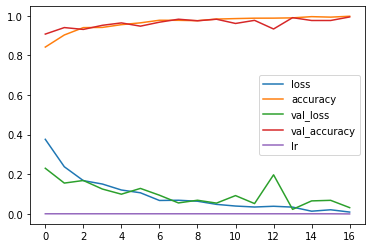

In [ ]:
pd.DataFrame(cnn.history.history).plot()

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

44/44 [==============================] - 8s 180ms/step - loss: 0.0136 - accuracy: 0.9943
The testing accuracy is : 99.42857027053833 %


In [ ]:
preds = cnn.predict(test,verbose=1)

44/44 [==============================] - 7s 163ms/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

Confussion Matrix

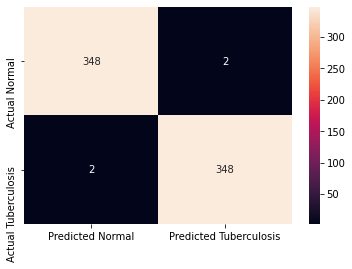

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Tuberculosis"],
columns=["Predicted Normal", "Predicted Tuberculosis"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

Classification Report

In [ ]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','TUBERCULOSIS']))

              precision    recall  f1-score   support

      NORMAL       0.99      0.99      0.99       350
TUBERCULOSIS       0.99      0.99      0.99       350

    accuracy                           0.99       700
   macro avg       0.99      0.99      0.99       700
weighted avg       0.99      0.99      0.99       700



(700, 500, 500, 1)
(700,)


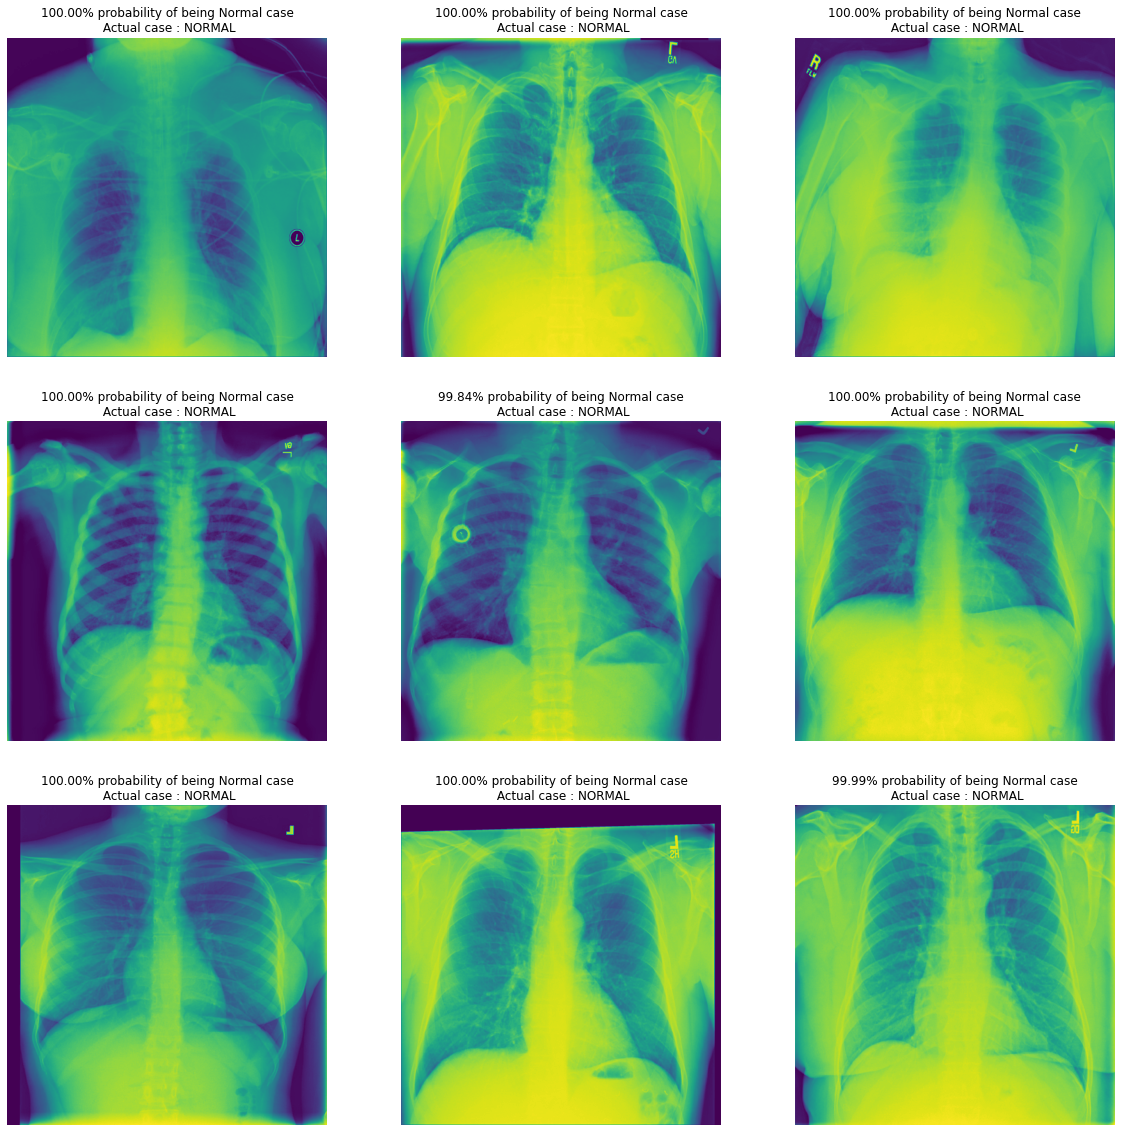

In [ ]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)
#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels 
dic = {0:'NORMAL', 1:'TUBERCULOSIS'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
    out = ('{:.2%} probability of being Tuberculosis case'.format(preds[i][0]))
      
      
  else: 
    out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()
